# Знакомство с Gym (продолжение)

В предыдущем уроке мы рассмотрели пример игры `Frozen Lake` и попробовали создать стратегию для игры а неё вручную. Перед тем, как переходить к обучению RL агентов, продолжим знакомство с Gym и рассмотрим пример более сложной игры -- `Pong` (одна из игра Atari). Особенность данной игры, во-первых, в более сложном состоянии, а во-вторых, в более сложном способе визуализации такого состояния. Эта игра будет содержать визуальное состояние, а игровой процесс будет содержать анимацию, поэтому для рендеринга игрового процесса Gym захочет создать дополнительное окно. Но так как мы работаем в Colab и дополнительных окон создать нельзя, нам придётся записывать игровой процесс на видео и потом воспроизводить его.

### Загрузка библиотек

Кроме Gym нам понадобятся `matplotlib` и `gym.wrappers.Monitor` для визуализации состояния игры.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import gym
from gym.wrappers import Monitor

### Создание игровой среды

Создаём среду игры `Pong` и смотрим на пространства действий и состояний.

Состояние теперь это целая RGB картинка -- то, что игрок видит на экране (Размерности 210 на 160).

Кроме того, есть 6 действий. По сути, это все достпуные действия на реальной консоли Atari. Просто в случае игры Pong лишь часть этих действий будут к чему-то приводить (в Pong нам просто нужно будет двигать нашу ракетку в одну или в другую сторону, то есть лишь два действия будут реально рабочими).


In [ ]:
env = gym.make('Pong-v0')

STATE_SHAPE = env.observation_space.shape
NUM_ACTIONS = env.action_space.n
ACTION_MEANING = env.unwrapped.get_action_meanings()

print('States shape: {}'.format(STATE_SHAPE))
print('Actions: {}'.format(NUM_ACTIONS))
print('Actions: {}'.format(ACTION_MEANING))

States shape: (210, 160, 3)
Actions: 6
Actions: ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


### Основные функции Gym

Приведём среду в исходное состояние, получим это состояние (`s`) и визуализируем его (это просто изображение)

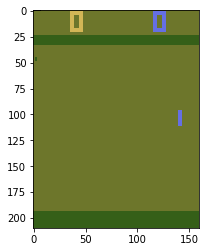

In [ ]:
s = env.reset()
_=plt.imshow(s)

Действия -- это по-прежнему просто числа (индекс действия)

In [ ]:
a = env.action_space.sample()
print(a)

3


Произведем один шаг игры и получим следующее состояние. В первые несколько шагов реальная игра еще не началась и наш противник еще не появился на поле.

Reward:  0.0
Done?  False


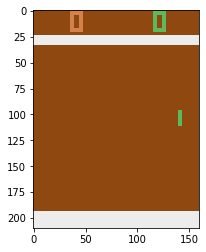

In [ ]:
s1, r, done, _ = env.step(a)
print('Reward: ', r)
print('Done? ', done)
_=plt.imshow(s1)

### Визуализация игрового процесса

Стандартная визуализация игрового процесса через `env.render()` в Colab работать не будет, так как Gym будет пытаться создать отдельное окно, где он будет рендерить игровую симуляцию (в движении).

In [ ]:
# env.render() # не работает в Colab

Один из способов обойти эту проблему -- записать симуляцию на видео (без открытия дополнительных окон) и потом воспроизвести это видео. Можно расценивать это как хак.

Для этого нам понадобится установить некоторые дополнительные пакеты и запустить виртуальный дисплей.

In [ ]:
if True: # Запустить этот блок нужно лишь один раз
  
    !apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
    !pip install pyvirtualdisplay > /dev/null 2>&1

    from pyvirtualdisplay import Display
    display = Display(visible=0, size=(1400, 900))
    display.start()

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


Для проигрывания видео, можно просто скачать его на свой компьютер и воспросизвести там. Но мы дополниельно создадим функцию для встраивания видеоплеера прямо в Colab. 

Данная функция `show_video()` ищет видео в папке `./video/` и вставляет его данные прямо в HTML данного Colab ноутбука. Так как видео целиком встраивается в веб-страницу, следует быть аккуратными с очень большими видео файлами.

In [ ]:
def show_video():
    import glob
    import io
    import base64
    from IPython.display import HTML
    from IPython import display as ipythondisplay

    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        print(mp4)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
            loop controls style="height: 400px;">
            <source src="data:video/mp4;base64,{0}" type="video/mp4" />
            </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")

Для того, чтобы перенаправить визуализацию нашей симуляции в видео файл, создадим объект `env_sim` клсса `Monitor` и будем использовать его вместо `env`

Для примера сделаем запись симуляции с одним шагом. 

* Переходим в начальное состояние с помощью `reset()`. В этот момент Монитор сбрасывает внутреннее состояние, начинает запись видео и захватывает первый кадр (соответствующей первому, текущему состоянию).
* Делаем шаг симуляции (функция `step` с действием `a=0`). В этот момент Монитор посылает реальной среде `env` указание "сделать шаг" и захватывает очередной кадр (соответствующий новому состоянию).
* Заканчиваем симуляцию с помощью `env_sim.close()`. В этот момент Монитор записывает все собранные кадры на диск в видео файл (в папке `./video`)

In [ ]:
env_sim = Monitor(env, './video', force=True)

s = env_sim.reset()
s, r, done, _ = env_sim.step(0)
env_sim.close()

Воспроизведем симулацию с помощью функции `show_video()`. Это видео состоит всего из двух кадров (первых двух состояний, в которых мы побывали). Первое состояние имеет неправильный цвет (особенность игры), поэтому видео получилось мерцающим.

In [ ]:
show_video()

video/openaigym.video.0.120.video000000.mp4


### Запуск симуляции

Теперь давате запустим полноценную симуляцию. Этот приактически такой же, как было в случае с Frozen Lake (спасибо Gym за удобный унифицированный интерфейс). В качестве стратегии будем как раньше использовать выбор случайного действия.

In [ ]:
env_sim = Monitor(env, './video', force=True)

s = env_sim.reset()
totalReward = 0

for _ in range(1000):
    env_sim.render()
    a = env_sim.action_space.sample() # случайная стратегия
    s, r, done, _ = env_sim.step(a)
    totalReward += r
    if r != 0:
        print('New reward = {}'.format(r))
    if done:        
        break
      
env_sim.close()

print('Total reward = {}'.format(totalReward))

New reward = -1.0
New reward = -1.0
New reward = -1.0
New reward = -1.0
New reward = -1.0
New reward = -1.0
New reward = -1.0
New reward = -1.0
New reward = -1.0
New reward = -1.0
New reward = -1.0
New reward = -1.0
New reward = -1.0
New reward = -1.0
New reward = -1.0
New reward = -1.0
New reward = -1.0
New reward = -1.0
New reward = -1.0
Total reward = -19.0


Воспроизведём симуляцию

In [ ]:
show_video()

video/openaigym.video.1.120.video000000.mp4


**[Задание 1]** Протестируйте другие игры из Gym: `Assault-v0` и `CarRacing-v0`. А именно, создайте соответствующую среду, монитор для записи видео и цикл симуляции со случайными действиями. В конце должен получиться видео файл с анимацией вашей симуляции (встроенный в Colab).

https://gym.openai.com/envs

Для некоторых симуляций может потребоваться установить расширение для gym: 

`!pip install 'gym[atari]'`

`!pip install 'gym[box2d]'`